# 0. Setup Paths

In [1]:
import os
import numpy as np
import re

In [2]:
CUSTOM_MODEL_NAME = 'ssdlite_mobiledet_edgetpu_tuned2' 
PRETRAINED_MODEL_NAME = 'ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/ssdlite_mobiledet_edgetpu_320x320_coco_2020_05_19.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'),
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [ ]:
# https://www.tensorflow.org/install/source_windows

In [ ]:
if os.name=='nt':
    !pip install wget
import wget
  

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf1\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
!pip install numpy

In [ ]:
pip show tensorflow-gpu


In [ ]:
!pip install tensorflow==1.15


In [ ]:
pip install tensorflow-text==1.15.1

In [6]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf1_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

2022-03-24 20:10:41.245146: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
Running tests under Python 3.7.10: D:\antrenare_cuant\TFODCourse\cuant\Scripts\python.exe
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
D:\antrenare_cuant\TFODCourse\cuant\lib\site-packages\tensorflow_core\python\training\tracking\data_structures.py:669: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(wrapped_dict, collections.Mapping):
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_experimental_model


In [ ]:
!pip show tensorflow-gpu

In [ ]:
!pip uninstall kiwisolver


In [ ]:
!pip uninstall protobuf matplotlib -y
!pip install protobuf matplotlib==3.2

In [ ]:
!pip install pillow

In [ ]:
import object_detection

In [ ]:
!pip list

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# 2. Create Label Map

In [6]:
labels = [{'name':'stop', 'id':1}, {'name':'straight ahead', 'id':2}, {'name':'limit60km', 'id':3}, {'name':'turn right', 'id':4}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

In [ ]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [7]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [8]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow\workspace\annotations\train.record
Successfully created the TFRecord file: Tensorflow\workspace\annotations\test.record


In [ ]:
!cd

# 4. Copy Model Config to Training Folder

In [8]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME,'fp32' ,'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME,'fp32', 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

        1 file(s) copied.


# 5. Update Config For Transfer Learning

In [7]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [22]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [23]:
config

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobiledet_edgetpu"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.9700000286102295
         center: true
         scale: true
         epsilon: 0.0010000000474974513
         train: true
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: false
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_thresho

In [24]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [25]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.num_steps = 20000
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME,'uint8', 'checkpoint', 'model.ckpt-400000')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]
# Enable ssdlite, this should already be enabled in the config we downloaded, but this is just to make sure.
pipeline_config.model.ssd.box_predictor.convolutional_box_predictor.kernel_size = 3
pipeline_config.model.ssd.box_predictor.convolutional_box_predictor.use_depthwise = True
pipeline_config.model.ssd.feature_extractor.use_depthwise = True
# Quantization Aware Training
pipeline_config.graph_rewriter.quantization.delay = 0
pipeline_config.graph_rewriter.quantization.weight_bits = 8
pipeline_config.graph_rewriter.quantization.activation_bits = 8

In [26]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 5.1. Evaluate


In [29]:
#%cd {paths['CHECKPOINT_PATH']}
import wget
import unzip

url="https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip"
wget.download(url) 
!tar -zxvf ngrok-stable-linux-amd64.zip

100% [........................................................................] 13832437 / 13832437

x ngrok


In [27]:
TRAINING_FOLDER = os.path.join(paths['CHECKPOINT_PATH'], 'train')

In [24]:
# Starts tensorboard, so we can monitor the training process.
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(paths['CHECKPOINT_PATH'])
)

In [25]:
get_ipython().system_raw('./ngrok http 6006 &')
print('Click this link to view training progress in TensorBoard:')

Click this link to view training progress in TensorBoard:


In [26]:
import time
time.sleep(1)
!curl -s http://localhost:4040/api/tunnels | python -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "C:\ProgramData\Anaconda3\lib\json\__init__.py", line 296, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "C:\ProgramData\Anaconda3\lib\json\__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "C:\ProgramData\Anaconda3\lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "C:\ProgramData\Anaconda3\lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


# 6. Train the model

In [9]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main.py')

In [9]:
gpus = tf.compat.v1.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.compat.v1.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.compat.v1.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [10]:
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.compat.v1.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Physical devices cannot be modified after being initialized


In [11]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [12]:
command = "python {} \
--model_dir={} \
--pipeline_config_path={} \
--logtostderr=true ".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [13]:
print(command)

python Tensorflow\models\research\object_detection\model_main.py --model_dir=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned2 --pipeline_config_path=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned2\pipeline.config --logtostderr=true 


In [ ]:
!{command}

# 7. Evaluate the Model

In [10]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [11]:
print(command)

python Tensorflow\models\research\object_detection\model_main.py --model_dir=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned2 --pipeline_config_path=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned2\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned2


In [ ]:
!{command}

# 8. Load Train Model From Checkpoint

In [12]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [13]:
#gaseste ultimul ckp
lst = os.listdir(paths['CHECKPOINT_PATH'])
# find the last model checkpoint file, i.e. model.ckpt-2000.meta
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(paths['CHECKPOINT_PATH'], last_model)
print(last_model_path)


Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned2\model.ckpt-20000


In [14]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v1.train.Checkpoint(model=detection_model)
ckpt.restore(last_model_path).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# 9. Freezing the Graph

In [15]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_inference_graph.py ')
CKP=os.path.join(paths['CHECKPOINT_PATH'], last_model)

In [16]:
command = "python {} \
--input_type=image_tensor \
--pipeline_config_path={} \
--output_directory={} \
--trained_checkpoint_prefix={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['OUTPUT_PATH'], CKP)

In [17]:
print(command)

python Tensorflow\models\research\object_detection\export_inference_graph.py  --input_type=image_tensor --pipeline_config_path=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned2\pipeline.config --output_directory=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned2\export --trained_checkpoint_prefix=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned2\model.ckpt-20000


In [18]:
!{command}

Parsing Inputs...

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0


2022-03-24 22:41:23.967619: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
Instructions for updating:
Please use `layer.__call__` method instead.
W0324 22:41:26.957442   508 deprecation.py:323] From D:\antrenare_cuant\TFODCourse\cuant\lib\site-packages\tf_slim\layers\layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0324 22:41:28.763342   508 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0324 22:41:28.825827   508 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0324 22:41:28.903934   508 convolutio

-min_cpu_micros             0
-min_params                 0
-min_float_ops              0
-min_occurrence             0
-step                       -1
-order_by                   name
-account_type_regexes       _trainable_variables
-start_name_regexes         .*
-trim_name_regexes          .*BatchNorm.*
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     params
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
param: Number of parameters (in the Variable).

Profile:
node name | # parameters
_TFProfRoot (--/3.28m params)
  BoxPredictor_0 (--/4.35k params)
    BoxPredictor_0/BoxEncodingPredictor (--/1.16k params)
      BoxPredictor_0/BoxEncodingPredictor/biases (12, 12/12 params)
      BoxPredictor_0/BoxEncodingPredictor/weights (1x1x96x12, 1.15k/1.15k params)
 

I0324 22:41:29.122632   508 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0324 22:41:29.325708   508 deprecation.py:323] From D:\antrenare_cuant\TFODCourse\cuant\lib\site-packages\object_detection-0.1-py3.7.egg\object_detection\core\post_processing.py:1157: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
W0324 22:41:29.513164   508 deprecation.py:323] From D:\antrenare_cuant\TFODCourse\cuant\lib\site-packages\object_detection-0.1-py3.7.egg\object_detection\exporter.py:474: get_or_create_global_step (from tf_slim.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.

    BoxPredictor_1/BoxEncodingPredictor (--/9.24k params)
      BoxPredictor_1/BoxEncodingPredictor/biases (24, 24/24 params)
      BoxPredictor_1/BoxEncodingPredictor/weights (1x1x384x24, 9.22k/9.22k params)
    BoxPredictor_1/BoxEncodingPredictor_depthwise (--/3.46k params)
      BoxPredictor_1/BoxEncodingPredictor_depthwise/BatchNorm (--/0 params)
      BoxPredictor_1/BoxEncodingPredictor_depthwise/depthwise_weights (3x3x384x1, 3.46k/3.46k params)
    BoxPredictor_1/ClassPredictor (--/11.55k params)
      BoxPredictor_1/ClassPredictor/biases (30, 30/30 params)
      BoxPredictor_1/ClassPredictor/weights (1x1x384x30, 11.52k/11.52k params)
    BoxPredictor_1/ClassPredictor_depthwise (--/3.46k params)
      BoxPredictor_1/ClassPredictor_depthwise/BatchNorm (--/0 params)
      BoxPredictor_1/ClassPredictor_depthwise/depthwise_weights (3x3x384x1, 3.46k/3.46k params)
  BoxPredictor_2 (--/36.92k params)
    BoxPredictor_2/BoxEncodingPredictor (--/12.31k params)
      BoxPredictor_2/BoxEnco

INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/FusedConv_5/Conv/add_fold
I0324 22:41:31.184643   508 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/FusedConv_5/Conv/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/FusedConv_6/Conv/add_fold
I0324 22:41:31.184643   508 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/FusedConv_6/Conv/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/FusedConv_7/Conv/add_fold
I0324 22:41:31.184643   508 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/FusedConv_7/Conv/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN/Conv/add_fold
I0324 22:41:31.184643   508 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN/Conv/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/IBN/SeparableConv2d/add_fold
I0324 22:41:31.184643   

# Real Time Detections from your Webcam

In [ ]:
!pip uninstall opencv-python-headless -y

In [ ]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# 10. Detect from an Image

In [19]:
import numpy as np
import os
import sys
import tensorflow as tf

from collections import defaultdict
from matplotlib import pyplot as plt
from PIL import Image

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
%matplotlib inline

In [20]:
# Initialize tf.Graph()
GRAPH=TRAINING_SCRIPT = os.path.join(paths['CHECKPOINT_PATH'], 'export','frozen_inference_graph.pb')
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')


In [21]:
# Loads labels
LABEL_MAP=os.path.join(paths['ANNOTATION_PATH'],'label_map.pbtxt')
label_map = label_map_util.load_labelmap(LABEL_MAP)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=4, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [22]:
# Run Inference and populates results in a dict.
def run_inference(graph, image):
  with graph.as_default():
    with tf.Session() as sess:
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = [output.name for op in ops for output in op.outputs]
      tensor_dict = {}
      tensor_keys = ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']
      for key in tensor_keys:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
      
      # Actual inference.
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
      output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
  return output_dict

Evaluating: Tensorflow\workspace\images\test\traffic-sign-arrow-right-turn-only-taxis-excepted-DE57FB.png


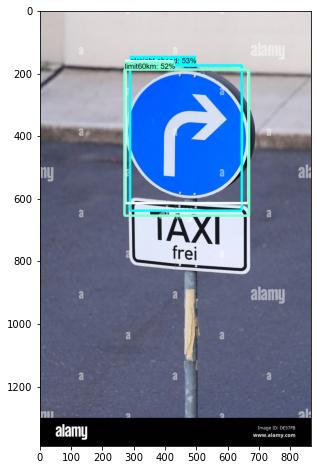

In [33]:
image_path = os.path.join(paths['IMAGE_PATH'], 'test','traffic-sign-arrow-right-turn-only-taxis-excepted-DE57FB.png')
print('Evaluating:', image_path)
image = Image.open(image_path)
img_width, img_height = image.size
image_np = np.array(image.getdata()).reshape((img_height, img_width, 3)).astype(np.uint8)
# Run inference.
output_dict = run_inference(detection_graph, image_np)
# Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
  image_np,
  output_dict['detection_boxes'],
  output_dict['detection_classes'],
  output_dict['detection_scores'],
  category_index,
  use_normalized_coordinates=True,
  line_thickness=8)
plt.figure(figsize=(12, 8))
plt.imshow(image_np)

# 12. Conversion to TFLite

In [34]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_ssd_graph.py')
#CKP=os.path.join(paths['CHECKPOINT_PATH'],'')

In [35]:
command = "python {} \
--pipeline_config_path={} \
--trained_checkpoint_prefix={} \
--output_directory={} \
--add_postprocessing_op=true".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], last_model_path, paths['TFLITE_PATH'])

In [36]:
print(command)

python Tensorflow\models\research\object_detection\export_tflite_ssd_graph.py --pipeline_config_path=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned2\pipeline.config --trained_checkpoint_prefix=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned2\model.ckpt-20000 --output_directory=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned2\tfliteexport --add_postprocessing_op=true


In [37]:
!{command}

2022-03-24 23:02:17.747870: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
Instructions for updating:
Please use `layer.__call__` method instead.
W0324 23:02:47.167524 16240 deprecation.py:323] From D:\antrenare_cuant\TFODCourse\cuant\lib\site-packages\tf_slim\layers\layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0324 23:02:49.108762 16240 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0324 23:02:49.169918 16240 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0324 23:02:49.231105 16240 convolutio

In [38]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'tflite_graph.pb')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'traffic.tflite')


2022-03-24 23:02:49.650804: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cublas64_100.dll
2022-03-24 23:02:49.650809: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cufft64_100.dll
2022-03-24 23:02:49.650815: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library curand64_100.dll
2022-03-24 23:02:49.650820: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cusolver64_100.dll
2022-03-24 23:02:49.650825: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cusparse64_100.dll
2022-03-24 23:02:49.650830: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudnn64_7.dll
2022-03-24 23:02:49.650863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Adding visible gpu devices: 0
2022-03-24 23:

INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_4_3x3_s2_256/add_fold
I0324 23:02:54.338477 16240 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_4_3x3_s2_256/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_1_Conv2d_5_1x1_64/add_fold
I0324 23:02:54.338477 16240 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_1_Conv2d_5_1x1_64/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_5_3x3_s2_128_depthwise/add_fold
I0324 23:02:54.338477 16240 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_5_3x3_s2_128_depthwise/add_fold
INFO:tensorflow:Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_5_3x3_s2_128/add_fold
I0324 23:02:54.338477 16240 quantize.py:299] Skipping quant after FeatureExtractor/MobileDetEdgeTPU/C5_2_Conv2d_5_3x3_s2_128/add_fold
INFO:tensorflow:Skipping quant a

In [39]:
command = "tflite_convert \
--output_file={} \
--graph_def_file={} \
--inference_type=QUANTIZED_UINT8 \
--input_arrays=normalized_input_image_tensor \
--output_arrays=TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3 \
--mean_values=128 \
--std_dev_values=128 \
--input_shapes=1,320,320,3 \
--allow_custom_ops".format(TFLITE_MODEL, FROZEN_TFLITE_PATH )


2022-03-24 23:02:55.833066: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-03-24 23:02:55.833072: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      0 
2022-03-24 23:02:55.833075: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1178] 0:   N 
2022-03-24 23:02:55.833153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1304] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 1337 MB memory) -> physical GPU (device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1)
INFO:tensorflow:Restoring parameters from Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned2\model.ckpt-20000
I0324 23:02:55.833959 16240 saver.py:1284] Restoring parameters from Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned2\model.ckpt-20000
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0324 23:02:57.802304 16240 

In [40]:
print(command)

tflite_convert --output_file=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned2\tfliteexport\traffic.tflite --graph_def_file=Tensorflow\workspace\models\ssdlite_mobiledet_edgetpu_tuned2\tfliteexport\tflite_graph.pb --inference_type=QUANTIZED_UINT8 --input_arrays=normalized_input_image_tensor --output_arrays=TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3 --mean_values=128 --std_dev_values=128 --input_shapes=1,320,320,3 --allow_custom_ops


In [41]:
!{command}

2022-03-24 23:03:03.666176: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
2022-03-24 23:03:24.108036: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library nvcuda.dll
2022-03-24 23:03:24.160843: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1050 major: 6 minor: 1 memoryClockRate(GHz): 1.493
pciBusID: 0000:01:00.0
2022-03-24 23:03:24.160878: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
2022-03-24 23:03:24.164771: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cublas64_100.dll
2022-03-24 23:03:24.168245: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cufft64_100.dll
2022-03-24 23:03:24.169956: I tensorflow/stream_executor/platform/defaul

# 13. Evaluarea modelului TFLITE

In [ ]:
import os
import re
import numpy as np
from PIL import Image
from PIL import ImageDraw
%matplotlib inline

# Creates tflite interpreter
interpreter = tf.lite.Interpreter(paths['TFLITE_PATH'] + '/traffic.tflite')
interpreter.allocate_tensors()
interpreter.invoke() # warmup
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
width = input_details[0]['shape'][2]
height = input_details[0]['shape'][1]

def read_label_file(file_path):
  with open(file_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()
  ret = {}
  for row_number, content in enumerate(lines):
    pair = re.split(r'[:\s]+', content.strip(), maxsplit=1)
    if len(pair) == 2 and pair[0].strip().isdigit():
      ret[int(pair[0])] = pair[1].strip()
    else:
      ret[row_number] = content.strip()
  return ret

def run_inference(interpreter, image):
  interpreter.set_tensor(input_details[0]['index'], image)
  interpreter.invoke()
  boxes = interpreter.get_tensor(output_details[0]['index'])[0]
  classes = interpreter.get_tensor(output_details[1]['index'])[0]
  scores = interpreter.get_tensor(output_details[2]['index'])[0]
  # num_detections = interpreter.get_tensor(output_details[3]['index'])[0]
  return boxes, classes, scores

image_path = os.path.join(paths['IMAGE_PATH'], 'test','stop-sign-road-sign-street.png')
print('Evaluating:', image_path)
image = Image.open(image_path)
image_width, image_height = image.size
draw = ImageDraw.Draw(image)
resized_image = image.resize((width, height))
np_image = np.asarray(resized_image)
input_tensor = np.expand_dims(np_image, axis=0)
# Run inference
boxes, classes, scores = run_inference(interpreter, input_tensor)
# Draw results on image
colors = {0:(128, 255, 102), 1:(102, 255, 255)}
labels = read_label_file(paths['ANNOTATIONS'] + '/labels.txt')
for i in range(len(boxes)):
    if scores[i] > .7:
      ymin = int(max(1, (boxes[i][0] * image_height)))
      xmin = int(max(1, (boxes[i][1] * image_width)))
      ymax = int(min(image_height, (boxes[i][2] * image_height)))
      xmax = int(min(image_width, (boxes[i][3] * image_width)))
      draw.rectangle((xmin, ymin, xmax, ymax), width=7, outline=colors[int(classes[i])])
      draw.rectangle((xmin, ymin, xmax, ymin-10), fill=colors[int(classes[i])])
      text = labels[int(classes[i])] + ' ' + str(scores[i]*100) + '%'
      draw.text((xmin+2, ymin-10), text, fill=(0,0,0), width=2)
    display(image)

# 14. Compilarea pentru Edge TPU

In [ ]:
#instalarea compilatorului
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
! sudo apt-get update
! sudo apt-get install edgetpu-compiler

In [ ]:
%cd paths['TFLITE_PATH']

! edgetpu_compiler -s traffic.tflite

# 15. Rularea pe Edge TPU

In [ ]:
wget https://c4.staticflickr.com/8/7580/15865399370_ffa5b49d20_z.jpg -O dog.jpg && \
wget https://c6.staticflickr.com/9/8534/8652503705_687d957a29_z.jpg -O cat.jpg

In [ ]:
git clone https://github.com/google-coral/pycoral

cd pycoral/examples/

python3 detect_image.py \
  --model ssdlite_mobiledet_dog_vs_cat_edgetpu.tflite \
  --labels labels.txt \
  --input dog.jpg \
  --output dog_result.jpg